# py-hanspell

**링크** : https://github.com/ssut/py-hanspell?tab=readme-ov-file#results
\
**설명** : 네이버 맞춤법 검사기를 이용한 파이썬용 한글 맞춤법 검사 라이브러리

**사용법**
1. ```git clone https://github.com/ssut/py-hanspell.git```
2. py-hanspell/spell_checker.py에서 ```payload = { "passportKey": '982cfda08159d4847b36bdce0ee8e691cce8ff75', 'color_blindness': '0', 'q': text }``` 부분의 passportKey의 value를 변경해줘야함
3. passportKey의 value는 네이버에서 맞춤법 검사기를 검색한 뒤 나오는 창에서 개발자도구[F12]를 연 뒤, Elements 부분에서 ctrl + F를 이용해 passportKey를 찾아서 복사 붙여넣기 하면 됨
4. ```python setup.py install```를 하거나 hanspell 폴더를 자신의 프로젝트 폴더 안에 포함시키면 사용 가능

In [1]:
from hanspell import spell_checker

In [2]:
# 테스트
result = spell_checker.check('안녕 하세요. 저는 한국인 입니다. 이문장은 한글로 작성됬습니다.')
result.as_dict()

{'result': True,
 'original': '안녕 하세요. 저는 한국인 입니다. 이문장은 한글로 작성됬습니다.',
 'checked': '안녕하세요. 저는 한국인입니다. 이 문장은 한글로 작성됐습니다.',
 'errors': 4,
 'words': OrderedDict([('안녕하세요.', 2),
              ('저는', 0),
              ('한국인입니다.', 2),
              ('이', 2),
              ('문장은', 2),
              ('한글로', 0),
              ('작성됐습니다.', 1)]),
 'time': 0.08581733703613281}

# G2P noise 찾기
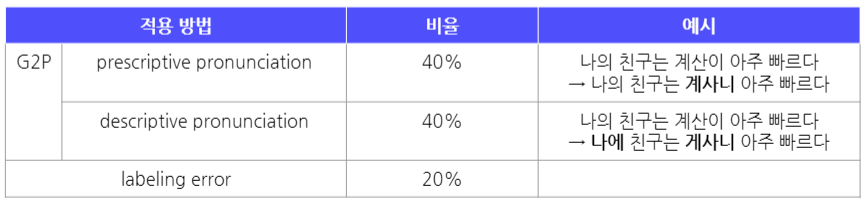

- 총 noise 데이터 개수는 6852개
- 그 중 80%에 해당하는 5,482개의 G2P 노이즈 데이터 존재
- Train에 몇 개가 존재하는가? -> 알 수 없음 -> Train의 noise를 잘 찾았는 지를 제대로 평가하기가 힘듬

### 데이터 불러오기

In [4]:
import pandas as pd
import numpy as numpy
from tqdm import tqdm

In [5]:
train_df = pd.read_csv('../data/train.csv')
train_df

,ID,text,target,url,date
0,ynat-v1_train_00000,개포2단지 분양 앞두고 개포지구 재건축 불붙어,1,https://news.naver.com/main/read.nhn?mode=LS2D...,2016.03.16. 오전 11:37
1,ynat-v1_train_00001,삼성전자 KBIS 2018서 셰프컬렉션 선보여,0,https://news.naver.com/main/read.nhn?mode=LS2D...,2018.01.10. 오전 8:33
2,ynat-v1_train_00002,LG G6 사면 BO 이어폰이 단돈 5천원,0,https://news.naver.com/main/read.nhn?mode=LS2D...,2017.04.30. 오전 10:00
3,ynat-v1_train_00003,신간 블록체인혁명 2030·남자의 고독사,3,https://news.naver.com/main/read.nhn?mode=LS2D...,2019.06.13. 오전 11:49
4,ynat-v1_train_00004,이스라엘 정보당국 팔레스타인인 50명 테러 혐의로 체포,4,https://news.naver.com/main/read.nhn?mode=LS2D...,2019.12.18. 오후 11:15
...,...,...,...,...,...
6995,ynat-v1_train_06995,힐만 SK 감독 고통스럽지만 내 상황 솔직히 알려야 해,5,https://sports.news.naver.com/news.nhn?oid=001...,2018.10.13 15:46
6996,ynat-v1_train_06996,정의장 사드 국회동의 사안 아니라 쳐도 충분히 협의해야,6,https://news.naver.com/main/read.nhn?mode=LS2D...,2016.07.17. 오후 6:20
6997,ynat-v1_train_06997,정치권 엘시티 수사 돌발변수에 촉각…왜 지금,6,https://news.naver.com/main/read.nhn?mode=LS2D...,2016.11.16. 오후 6:24
6998,ynat-v1_train_06998,문 대통령 1987 관람…깜짝 방문에 객석 환호·박수종합,6,https://news.naver.com/main/read.nhn?mode=LS2D...,2018.01.07. 오후 5:23


In [6]:
# text에 대해 spell_checker.check 함수를 이용한 맞춤법 검사를 apply 함수를 이용해 적용하고 .as_dict()까지 적용한 최종 결과를 text_checked라는 새로운 컬럼에 저장
tqdm.pandas()
train_df['text_checked'] = train_df['text'].progress_apply(lambda x: spell_checker.check(x).as_dict())

100%|██████████| 7000/7000 [03:26<00:00, 33.85it/s]


In [10]:
# 저장
train_df.to_csv('../data/temp_train_checked.csv', index=False)

In [7]:
train_df

,ID,text,target,url,date,text_checked
0,ynat-v1_train_00000,개포2단지 분양 앞두고 개포지구 재건축 불붙어,1,https://news.naver.com/main/read.nhn?mode=LS2D...,2016.03.16. 오전 11:37,"{'result': True, 'original': '개포2단지 분양 앞두고 개포지..."
1,ynat-v1_train_00001,삼성전자 KBIS 2018서 셰프컬렉션 선보여,0,https://news.naver.com/main/read.nhn?mode=LS2D...,2018.01.10. 오전 8:33,"{'result': True, 'original': '삼성전자 KBIS 2018서 ..."
2,ynat-v1_train_00002,LG G6 사면 BO 이어폰이 단돈 5천원,0,https://news.naver.com/main/read.nhn?mode=LS2D...,2017.04.30. 오전 10:00,"{'result': True, 'original': 'LG G6 사면 BO 이어폰이..."
3,ynat-v1_train_00003,신간 블록체인혁명 2030·남자의 고독사,3,https://news.naver.com/main/read.nhn?mode=LS2D...,2019.06.13. 오전 11:49,"{'result': True, 'original': '신간 블록체인혁명 2030·남..."
4,ynat-v1_train_00004,이스라엘 정보당국 팔레스타인인 50명 테러 혐의로 체포,4,https://news.naver.com/main/read.nhn?mode=LS2D...,2019.12.18. 오후 11:15,"{'result': True, 'original': '이스라엘 정보당국 팔레스타인인..."
...,...,...,...,...,...,...
6995,ynat-v1_train_06995,힐만 SK 감독 고통스럽지만 내 상황 솔직히 알려야 해,5,https://sports.news.naver.com/news.nhn?oid=001...,2018.10.13 15:46,"{'result': True, 'original': '힐만 SK 감독 고통스럽지만 ..."
6996,ynat-v1_train_06996,정의장 사드 국회동의 사안 아니라 쳐도 충분히 협의해야,6,https://news.naver.com/main/read.nhn?mode=LS2D...,2016.07.17. 오후 6:20,"{'result': True, 'original': '정의장 사드 국회동의 사안 아..."
6997,ynat-v1_train_06997,정치권 엘시티 수사 돌발변수에 촉각…왜 지금,6,https://news.naver.com/main/read.nhn?mode=LS2D...,2016.11.16. 오후 6:24,"{'result': True, 'original': '정치권 엘시티 수사 돌발변수에..."
6998,ynat-v1_train_06998,문 대통령 1987 관람…깜짝 방문에 객석 환호·박수종합,6,https://news.naver.com/main/read.nhn?mode=LS2D...,2018.01.07. 오후 5:23,"{'result': True, 'original': '문 대통령 1987 관람…깜짝..."


In [8]:
# train_df의 text를 text_checked의 checked로 대체
new_train_df = train_df.copy()
new_train_df['text'] = train_df['text_checked'].apply(lambda x: x['checked'])
# text_checked 컬럼 삭제
new_train_df.drop('text_checked', axis=1, inplace=True)

new_train_df

,ID,text,target,url,date
0,ynat-v1_train_00000,개포 2단지 분양 앞두고 개포지구 재건축 불붙어,1,https://news.naver.com/main/read.nhn?mode=LS2D...,2016.03.16. 오전 11:37
1,ynat-v1_train_00001,삼성전자 KBIS 2018 서 셰프 컬렉션 선보여,0,https://news.naver.com/main/read.nhn?mode=LS2D...,2018.01.10. 오전 8:33
2,ynat-v1_train_00002,LG G6 사면 BO 이어폰이 단돈 5천 원,0,https://news.naver.com/main/read.nhn?mode=LS2D...,2017.04.30. 오전 10:00
3,ynat-v1_train_00003,신간 블록체인 혁명 2030·남자의 고독사,3,https://news.naver.com/main/read.nhn?mode=LS2D...,2019.06.13. 오전 11:49
4,ynat-v1_train_00004,이스라엘 정보당국 팔레스타인인 50명 테러 혐의로 체포,4,https://news.naver.com/main/read.nhn?mode=LS2D...,2019.12.18. 오후 11:15
...,...,...,...,...,...
6995,ynat-v1_train_06995,일만 SK 감독 고통스럽지만 내 상황 솔직히 알려야 해,5,https://sports.news.naver.com/news.nhn?oid=001...,2018.10.13 15:46
6996,ynat-v1_train_06996,정 의장 사드 국회 동의 사안 아니라 쳐도 충분히 협의해야,6,https://news.naver.com/main/read.nhn?mode=LS2D...,2016.07.17. 오후 6:20
6997,ynat-v1_train_06997,정치권 엘시티 수사 돌발변수에 촉각…왜 지금,6,https://news.naver.com/main/read.nhn?mode=LS2D...,2016.11.16. 오후 6:24
6998,ynat-v1_train_06998,문 대통령 1987 관람…깜짝 방문에 객석 환호·박수 종합,6,https://news.naver.com/main/read.nhn?mode=LS2D...,2018.01.07. 오후 5:23


In [9]:
# 저장
new_train_df.to_csv('../data/train_spell_checked.csv', index=False)

- 에러의 종류

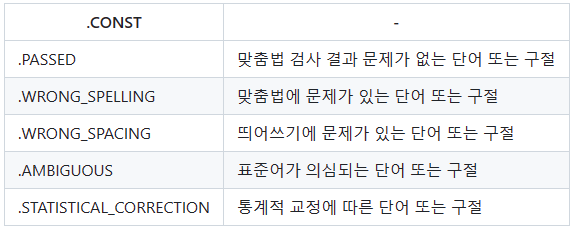

In [11]:
train_df['text_checked'][0]

{'result': True,
 'original': '개포2단지 분양 앞두고 개포지구 재건축 불붙어',
 'checked': '개포 2단지 분양 앞두고 개포지구 재건축 불붙어',
 'errors': 1,
 'words': OrderedDict([('개포', 2),
              ('2단지', 2),
              ('분양', 0),
              ('앞두고', 0),
              ('개포지구', 0),
              ('재건축', 0),
              ('불붙어', 0)]),
 'time': 0.023388147354125977}

- 위와 같이 띄어쓰기도 에러에 속함을 확인

- G2P는 어떤 에러에 속하는가?
  - 정성 분석을 통해 뽑은 샘플들의 공통 에러를 확인

- 데이터 정성분석을 통한 G2P 샘플 10개 추출

    ```
    ynat-v1_train_00020	당대 최고 포수 양이지 올 시즌 성적 쩌도 신기함니다 5
    ynat-v1_train_00024	이뤄 뢰구긴 관광개 길보니 한구긔 이배…격차 계소 콱때되나 1
    ynat-v1_train_00050	유니테스트 SK하이닉쓰와 칠시보어권 반도체 장비 공급께약	1
    ynat-v1_train_00058	사월부터 통신사 고객쎈터 점심시가넨 긴급쌍담만 반는다	2
    ynat-v1_train_00062	인테리어로 스마트홈 구축…SKT 에코인테리어혀푀와 MOU	2
    ynat-v1_train_00079	SKT 삼심마눤대 스마트폰 갤럭씨 와이드 단독 출시 0
    ynat-v1_train_00098	유엘 리비아 내저 나콰·국쩨저 콱싸 누려…아라변맹 긴그푀의    4
    ynat-v1_train_00111	자고나면 한 명씽 느느 녜비후보…열기 다라오르는 서부산	6
    ynat-v1_train_00112	예상모탄 결과서 노벨상 나온다…게소 견구지워니 중요	0
    ynat-v1_train_00118	제오회 수림문학쌍 오늘부터 공모…장편소설 대상	3
    ```

In [12]:
g2p_10 = ['당대 최고 포수 양이지 올 시즌 성적 쩌도 신기함니다',
          '이뤄 뢰구긴 관광개 길보니 한구긔 이배…격차 계소 콱때되나',
          '유니테스트 SK하이닉쓰와 칠시보어권 반도체 장비 공급께약',
          '사월부터 통신사 고객쎈터 점심시가넨 긴급쌍담만 반는다',
          '인테리어로 스마트홈 구축…SKT 에코인테리어혀푀와 MOU',
          'SKT 삼심마눤대 스마트폰 갤럭씨 와이드 단독 출시',
          '유엘 리비아 내저 나콰·국쩨저 콱싸 누려…아라변맹 긴그푀의',
          '자고나면 한 명씽 느느 녜비후보…열기 다라오르는 서부산',
          '예상모탄 결과서 노벨상 나온다…게소 견구지워니 중요',
          '제오회 수림문학쌍 오늘부터 공모…장편소설 대상']

In [16]:
g2p_10_result = spell_checker.check(g2p_10)
g2p_10_result = [r.as_dict() for r in g2p_10_result]

In [25]:
g2p_10_result[5]

{'result': True,
 'original': 'SKT 삼심마눤대 스마트폰 갤럭씨 와이드 단독 출시',
 'checked': 'SKT 삼심마눤대 스마트폰 갤럭시 와이드 단독 출시',
 'errors': 2,
 'words': OrderedDict([('SKT', 0),
              ('삼심마눤대', 3),
              ('스마트폰', 0),
              ('갤럭시', 4),
              ('와이드', 0),
              ('단독', 0),
              ('출시', 0)]),
 'time': 0.07184624671936035}

In [38]:
from collections import Counter

In [52]:
# g2p_10_result의 words에서 value값만 리스트에 저장
errors = [0,0,0,0,0]
for r in g2p_10_result:

    for i in range(5):
        if i in r['words'].values():
            errors[i] += 1
    
    print(r['original'],'|', set(r['words'].values()), '|', r['checked'])

당대 최고 포수 양이지 올 시즌 성적 쩌도 신기함니다 | {0, 1} | 당대 최고 포수 양이지 올 시즌 성적 쩌도 신기합니다
이뤄 뢰구긴 관광개 길보니 한구긔 이배…격차 계소 콱때되나 | {0, 2, 3, 4} | 이뤄 뢰구긴 관광객 길보니 한구긔 이배…격차 계소 콱 때 되나
유니테스트 SK하이닉쓰와 칠시보어권 반도체 장비 공급께약 | {0, 2, 4} | 유니테스트 SK하이닉스와 칠 시 보어권 반도체 장비 공급께 약
사월부터 통신사 고객쎈터 점심시가넨 긴급쌍담만 반는다 | {0, 1, 3, 4} | 사월부터 통신사 고객센터 점심시가넨 긴급상담만 박는다
인테리어로 스마트홈 구축…SKT 에코인테리어혀푀와 MOU | {0, 2, 3} | 인테리어로 스마트홈 구축… SKT 에코인테리어혀푀와 MOU
SKT 삼심마눤대 스마트폰 갤럭씨 와이드 단독 출시 | {0, 3, 4} | SKT 삼심마눤대 스마트폰 갤럭시 와이드 단독 출시
유엘 리비아 내저 나콰·국쩨저 콱싸 누려…아라변맹 긴그푀의 | {0, 2, 3} | 유엘 리비아 내저 나콰·국쩨저 콱 싸 누려…아라변맹 긴그푀의
자고나면 한 명씽 느느 녜비후보…열기 다라오르는 서부산 | {0, 2, 4} | 자고 나면 한 명 씽 느는 네비 후보…열기 다라 오르는 서부산
예상모탄 결과서 노벨상 나온다…게소 견구지워니 중요 | {0, 3, 4} | 예상 못 탄 결과서 노벨상 나온다…기소 견구지워니 중요
제오회 수림문학쌍 오늘부터 공모…장편소설 대상 | {0, 2, 3} | 제 오 회 수림문학쌍 오늘부터 공모…장편소설 대상


In [47]:
errors

[10, 2, 6, 7, 6]

**G2P 데이터에 대한 hanspell 맞춤법 교정 결과 분석**

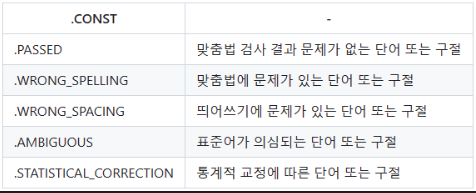

- 맞춤법에 문제가 있는 단어 또는 구절 : 2개
- 띄어쓰기에 문제가 있는 단어 또는 구절 : 6개
- 표준어가 의심되는 단어 또는 구절 : 7개
- 통계적 교정에 따른 단어 또는 구절 : 6개

- 문제는, 2,3,4에 해당하는 오류를 맞춤법 교정 모델이 교정하지 못함
- 2,3,4에 해당하는 구어체들을 문어체로 바꾸는 모델 사용(필요하다면 모델 성능 평가 및 개선 후 리더보드 성능 비교)